## MOIRAI Usage Example

### Key features of the model:
- **Multi-patch Layers:** Adapts to different granularities (frequencies) - different patch size for each granularity
- **Probabilistic:** Predicts params of mix of distributions along with a confidence score for each distribution

### Loading MOIRAI Model

In [1]:
# External imports
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

# Local imports
from samay.dataset import MoiraiDataset
from samay.model import MoiraiTSModel
from samay.utils import visualize, read_yaml, prep_finetune_config

# Load the pretrained model
repo = "Salesforce/moirai-moe-1.0-R-small"
config = {
        "context_len": 128,
        "horizon_len": 64,
        "num_layers": 100,
        "model_type": "moirai-moe",
        "model_size": "small"
    }

moirai_model = MoiraiTSModel(repo=repo, config=config)

### Define the datasets

In [2]:
# Config for the electric transformer temperature dataset
data_config = {"name" : "Etth1",
                "path" : "../src/samay/models/moment/data/ETTh1.csv",
                "date_col" : "date",
                "freq": "h"
            }

df = pd.read_csv(data_config["path"])
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


Here, we have 6 input features (all form `input_ts`) and the target column is the *Oil Temperature* (`OT`)

In [3]:
# test dataset - for zero-shot forecasting
test_dataset = MoiraiDataset(
    name=data_config['name'],
    mode="test",
    path=data_config['path'],
    datetime_col=data_config['date_col'],
    freq=data_config['freq'],
    context_len=config['context_len'],
    horizon_len=config['horizon_len'],
)

Normalizing the dataset


### Evaluate zero-shot forecasting

In [4]:
%%time
metrics, trues, preds, histories = moirai_model.evaluate(test_dataset)
print(metrics)

Forecasting done....now testing
{'mse': 0.5510688139980967, 'mae': 0.48572111090349057, 'mase': nan, 'mape': 0.7832093537697995, 'rmse': 0.7151227815439498, 'nrmse': 0.12267408530803411, 'smape': 0.8058383181197558, 'msis': 0.1045896892968985, 'nd': 4.476238669136719}
CPU times: user 14.9 s, sys: 130 ms, total: 15.1 s
Wall time: 13.1 s


/nethome/sanand315/Samay/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nethome/sanand315/Samay/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Visualise forecast for a given window

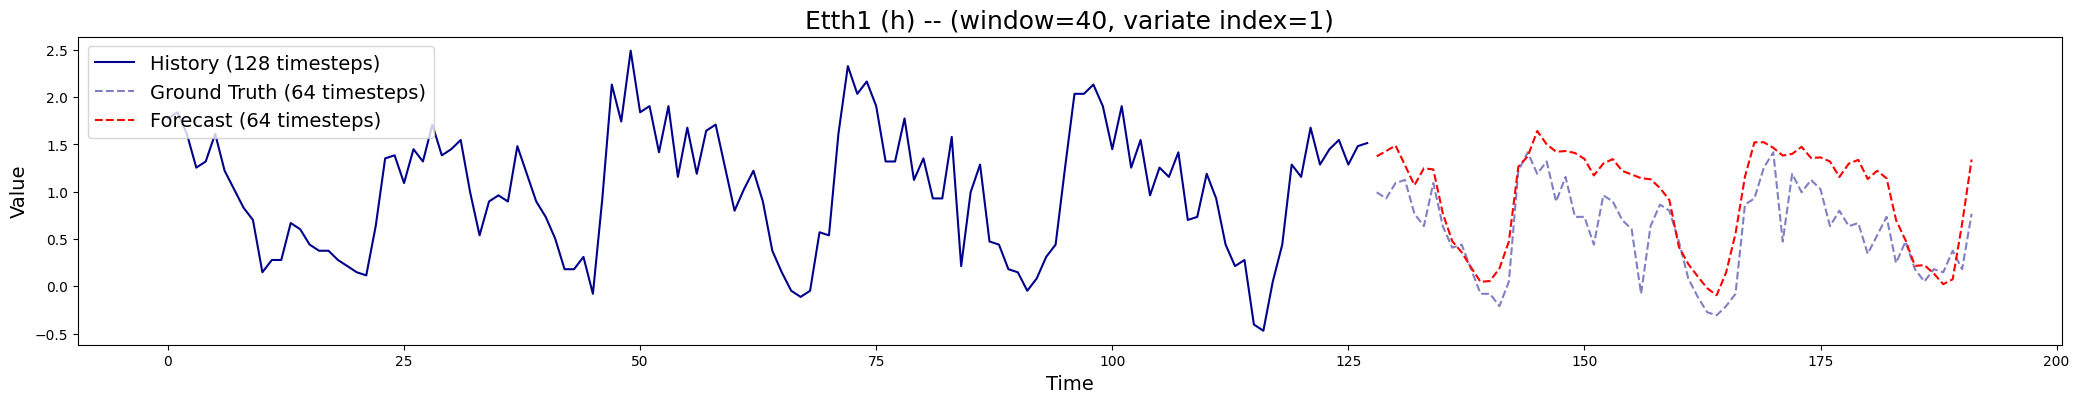

In [5]:
select = {"dataset":data_config["name"], "freq":data_config["freq"]}
visualize(context_len=config["context_len"], trues=trues, preds=preds, history=histories,**select)

### Finetune MOIRAI on ETT Dataset

In [6]:
path = "../src/samay/models/uni2ts/cli/conf/finetune/model/moirai_small.yaml"
fin_config = read_yaml(path)

fin_config.keys()

dict_keys(['_target_', 'module_kwargs', 'min_patches', 'min_mask_ratio', 'max_mask_ratio', 'max_dim', 'loss_func', 'val_metric', 'lr', 'weight_decay', 'beta1', 'beta2', 'num_training_steps', 'num_warmup_steps', 'checkpoint_path'])

In [7]:
data_config_path = "../src/samay/models/uni2ts/cli/conf/finetune/default.yaml"
torch_config = read_yaml(data_config_path)
ft_kwargs = prep_finetune_config(data_config_path)

In [8]:
# Number of input features to Input projection layer is the patch size used by the model
patch_size = moirai_model.model.module.in_proj.in_features_ls[0]
patch_size

16

In [9]:
# Train dataset
train_dataset = MoiraiDataset(
    name=data_config['name'],
    mode="train",
    path=data_config['path'],
    datetime_col=data_config['date_col'],
    freq=data_config['freq'],
    context_len=config['context_len'],
    horizon_len=config['horizon_len'],
    patch_size=patch_size,
    kwargs=torch_config["train_dataloader"]
)

Normalizing the dataset


Epoch 0: Loss: -4.677
Epoch 1: Loss: -4.890
Epoch 2: Loss: -5.012
Epoch 3: Loss: -5.110
Epoch 4: Loss: -5.179
Finetuning done
Fineuned model updated
CPU times: user 10min 22s, sys: 1min 15s, total: 11min 37s
Wall time: 10min 57s


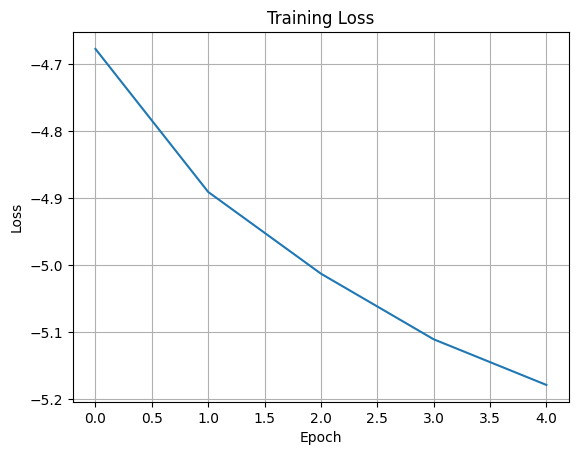

In [10]:
%%time
moirai_model.finetune(train_dataset, **ft_kwargs)

### Evaluate finetuned model

In [11]:
%%time
metrics, trues, preds, histories = moirai_model.evaluate(test_dataset,zero_shot=False)
print(metrics)

Forecasting done....now testing
{'mse': 0.5854820964631351, 'mae': 0.49091478003007266, 'mase': nan, 'mape': 0.8477040898036464, 'rmse': 0.7300281534394871, 'nrmse': 0.12493725587962691, 'smape': 0.7982925577925196, 'msis': 0.1039090474914235, 'nd': 4.86741192477461}
CPU times: user 14 s, sys: 29.5 ms, total: 14 s
Wall time: 12.1 s


/nethome/sanand315/Samay/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nethome/sanand315/Samay/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Visualise forecast for a given window

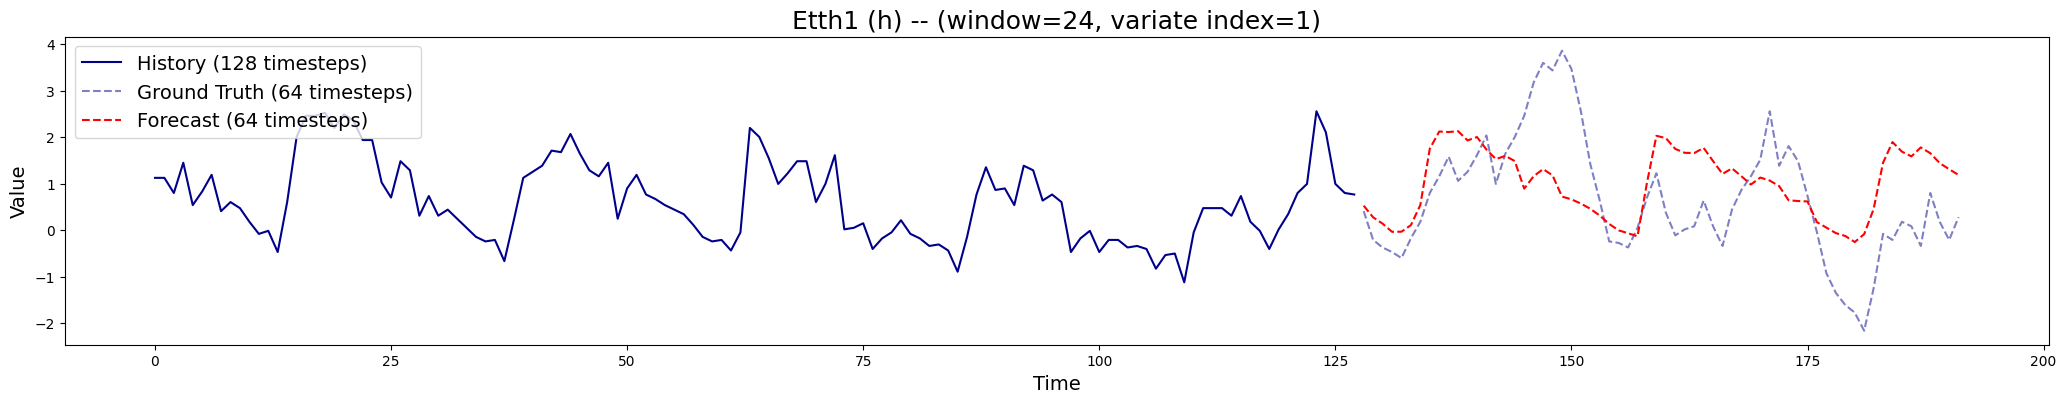

In [12]:
visualize(context_len=config["context_len"], trues=trues, preds=preds, history=histories,**select)